In [1]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *

import warnings
warnings.filterwarnings('ignore')

## First load a few images to identify ROIs and check threshold

In [2]:
pgroup='p19262'
fc = FileChooser(f'/sf/alvra/data/{pgroup}/raw/scan_data')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19262/raw/scan_data', filename='', title='HTML(value='', layout=Layout(displ…

In [3]:
nshots = 100
threshold_low = 2
threshold_high = 10

######################################################################

total_image, total_image_thr, total_for_hist, total_for_hist_thr = \
XES_static_full(fc.selected, pgroup, threshold_low, threshold_high, nshots)

Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p19262/raw/JF_pedestals/run_011280.JF02T09V02.res.h5
jungfrau file: 11:38 04.12.2021
pedestal file: 09:32 04.12.2021
    mtime difference: 2:06:14.880069
Loaded 100 images
Now summing up 100 images...
It took 6.99 seconds to process this file


<IPython.core.display.Javascript object>


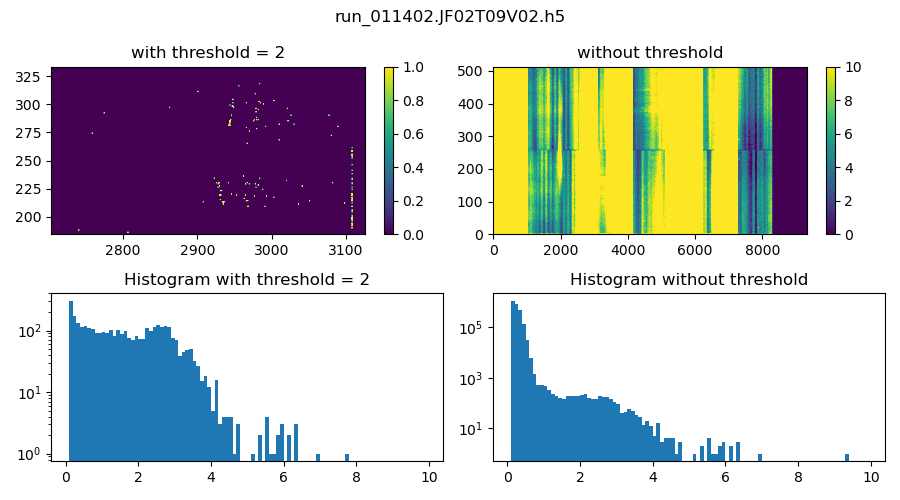

In [4]:
plt.figure(figsize=(9,5))
plt.suptitle(fc.selected_filename)
plt.subplots_adjust(wspace=0.5)

plt.subplot(221)
plt.imshow(total_image_thr, origin="lower", aspect='auto', vmin=0, vmax=1)
plt.title("with threshold = {}".format(threshold_low))
plt.colorbar()

plt.subplot(223)
plt.title("Histogram with threshold = {}".format(threshold_low))
plt.hist(total_for_hist_thr.ravel(), bins=np.arange(0.1,10,0.1))
plt.yscale('log')

plt.subplot(222)
plt.imshow(total_image, origin="lower", aspect='auto', vmin=0, vmax=10)
plt.title("without threshold")
plt.colorbar()

plt.subplot(224)
plt.title("Histogram without threshold")
plt.hist(total_for_hist.ravel(), bins=np.arange(0.1,10,0.1))
plt.yscale('log')

plt.tight_layout()
plt.show()

## Load the calibration scan

In [2]:
pgroup = 'p19262'
fc = FileChooser(f'/sf/alvra/data/{pgroup}/raw/scan_info')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19262/raw/scan_info', filename='', title='HTML(value='', layout=Layout(displ…

In [3]:
roi1 = (2900, 3100, 180, 260) #signal CRY2 low
roi2 = (2900, 3100, 250, 330) #signal CRY2 up

roi3 = (7200, 7500, 200, 240) #signal CRY1 low
roi4 = (7200, 7500, 270, 310) #signal CRY1 up

threshold_low = 2
threshold_high = 10
nshots = None

correctFlag = (True,True,False,False)
binsize = 5
#####################################################################################

RIXS_roi1, RIXS_roi2, RIXS_roi3, RIXS_roi4, Energy_eV,pids = \
RIXS_static_4ROIs(fc.selected, pgroup, roi1, roi2, roi3, roi4, threshold_low, threshold_high, nshots, correctFlag, binsize)


It took 5.23 seconds to process this file

Job done! It took 483.24 seconds to process 51 file(s)


<IPython.core.display.Javascript object>


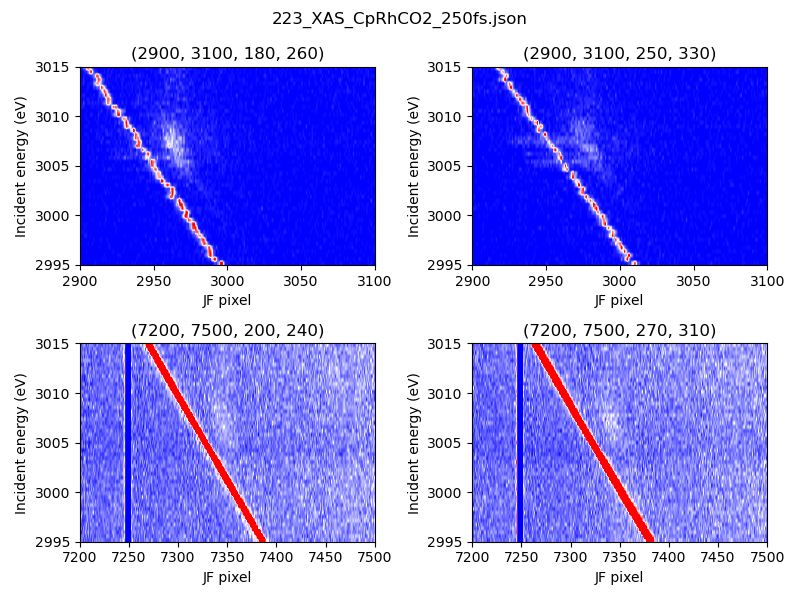

In [4]:
fig = plt.figure(figsize=(8, 6))
plt.suptitle(fc.selected_filename)

RIXSarray = [RIXS_roi1, RIXS_roi2, RIXS_roi3, RIXS_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    RIXS_roi = RIXSarray[i]
    roi = roiarray[i]

    location = 221+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.imshow(RIXS_roi,aspect = 'auto', cmap='bwr',origin='lower',\
             extent=[roi[0], roi[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=100)
    ax.set_xlabel('JF pixel')
    ax.set_ylabel('Incident energy (eV)')
    
    ax.set_title(str(roiarray[i]))
    
plt.tight_layout()

## Energy calibration

In [5]:
savedir = f'/das/work/p19/p19262/JF_XES_calibration/'
os.makedirs(savedir, exist_ok = True)

<IPython.core.display.Javascript object>


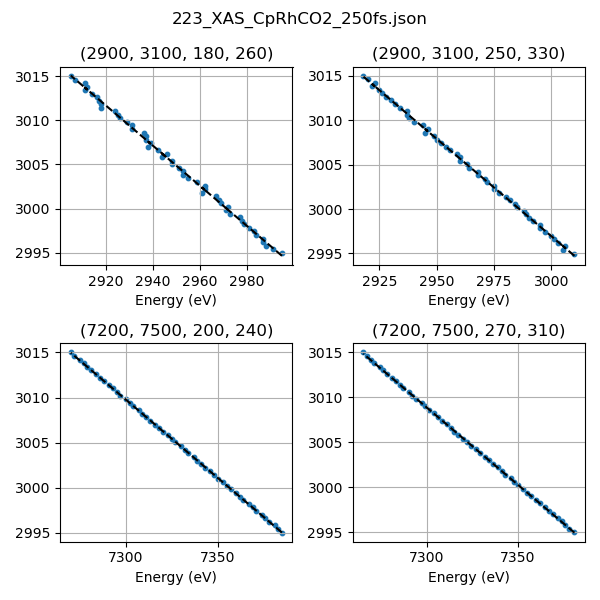

m = -0.22675630012706888 eV/pixel
b = 3673.786163340428 eV
m = -0.21914029778207983 eV/pixel
b = 3654.349029240717 eV
m = -0.17350213734438524 eV/pixel
b = 4276.327851211191 eV
m = -0.17169046891590736 eV/pixel
b = 4262.194558310037 eV


In [6]:
fig = plt.figure(figsize=(6, 6))
plt.suptitle(fc.selected_filename)

RIXSarray = [RIXS_roi1, RIXS_roi2, RIXS_roi3, RIXS_roi4]
roiarray = [roi1, roi2, roi3, roi4]

m_all = []
b_all = []
for i in range(4):
    RIXS_roi = RIXSarray[i]
    roi = roiarray[i]
    m,b, maxpos = energy_calib(RIXS_roi, roi, Energy_eV, 0, 51)
    m_all.append(m)
    b_all.append(b)

    location = 221+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.scatter(maxpos, Energy_eV, s = 10)
    ax.plot(maxpos, m*(maxpos) + b,  '--', color='black')
    ax.grid()
    ax.set_xlabel('pixel')
    ax.set_xlabel('Energy (eV)')

    ax.set_title(str(roiarray[i]))
plt.tight_layout()

np.savetxt(savedir+fc.selected_filename+'_m_all.txt', m_all)
np.savetxt(savedir+fc.selected_filename+'_b_all.txt', b_all)

## Load calibration parameters

In [7]:
m_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_m_all.txt')
b_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_b_all.txt')

## Check calibration

<IPython.core.display.Javascript object>


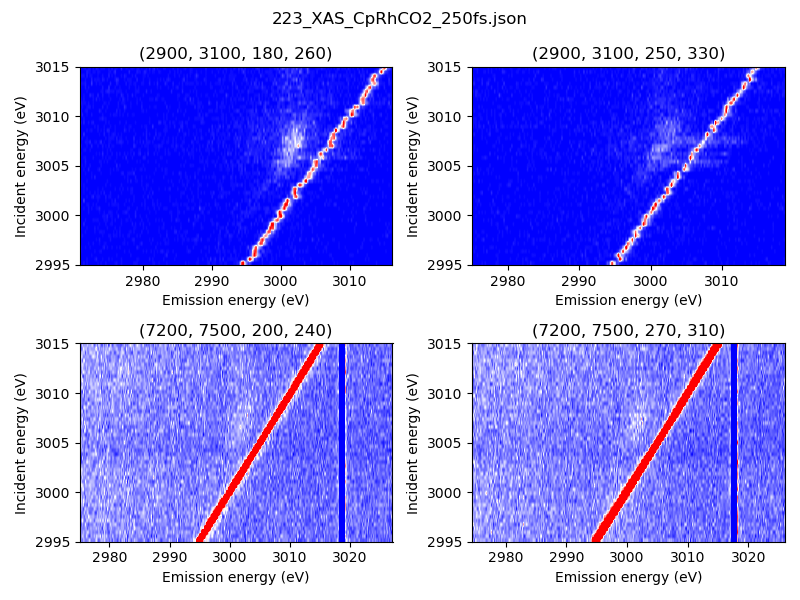

In [8]:
fig = plt.figure(figsize=(8, 6))
plt.suptitle(fc.selected_filename)

RIXSarray = [RIXS_roi1, RIXS_roi2, RIXS_roi3, RIXS_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    RIXS_roi = RIXSarray[i]
    roi = roiarray[i]
    
    xaxis = np.linspace(roi[0]*m_all[i]+b_all[i], roi[1]*m_all[i]+b_all[i], roi[1]-roi[0])
    
    location = 221+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.imshow(RIXS_roi,aspect = 'auto', cmap='bwr',origin='lower',\
             extent=[xaxis[0], xaxis[-1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=100)
    ax.set_xlabel('Emission energy (eV)')
    ax.set_ylabel('Incident energy (eV)')
    ax.invert_xaxis()
    
    ax.set_title(str(roiarray[i]))
    
plt.tight_layout()